In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import analyze_cells_energy as ace
import re
import utils
import itertools
import seaborn as sns
import utils_PLS as upls

In [7]:
# load query file where we added volumes for each area
volumes = ace.clean_volumes_database()

In [8]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'C57_MaleUrine_Exposure_cFos'
batch='c57'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
dict_results_across_mice = np.load('dict_results/newvolumes/dict_results_across_mice_c57_merged_hemispheres.npy', allow_pickle=True).item()

In [9]:
dict_results_across_mice = upls.reformat_dict_acronym(dict_results=dict_results_across_mice, volumes=volumes)

# Format data for task PLS

In [10]:
data_ncells = upls.format_data_pls(dict_results=dict_results_across_mice, 
                                   batch=batch, table='n_cells')
data_energy = upls.format_data_pls(dict_results=dict_results_across_mice, 
                                   batch=batch, table='energy')
data_density = upls.format_data_pls(dict_results=dict_results_across_mice, 
                                    batch=batch, table='density')
data_relative_density = upls.format_data_pls(dict_results=dict_results_across_mice, 
                                             batch=batch, table='relative_density')
data_ncells.dropna(inplace=True, axis=1)
data_energy.dropna(inplace=True, axis=1)
data_density.dropna(inplace=True, axis=1)
data_relative_density.dropna(inplace=True, axis=1)
data_ncells.to_csv('./results_pls/'+batch+'_n_cells.csv')
data_energy.to_csv('./results_pls/'+batch+'_energy.csv')
data_density.to_csv('./results_pls/'+batch+'_density.csv')
data_relative_density.to_csv('./results_pls/'+batch+'_relative_density.csv')

# Format data for hierarchy plotting

In [11]:
df_levels = upls.create_df_levels(volumes)

# Apply task PLS

In [12]:
%%bash
python area_pls.py -i results_pls/c57_n_cells.csv -o './results_pls/c57_ncells'

In [13]:
%%bash
python area_pls.py -i results_pls/c57_energy.csv -o './results_pls/c57_energy'

In [14]:
%%bash
python area_pls.py -i results_pls/c57_density.csv -o './results_pls/c57_density'

In [15]:
%%bash
python area_pls.py -i results_pls/c57_relative_density.csv -o './results_pls/c57_relative_density'

# Plot results

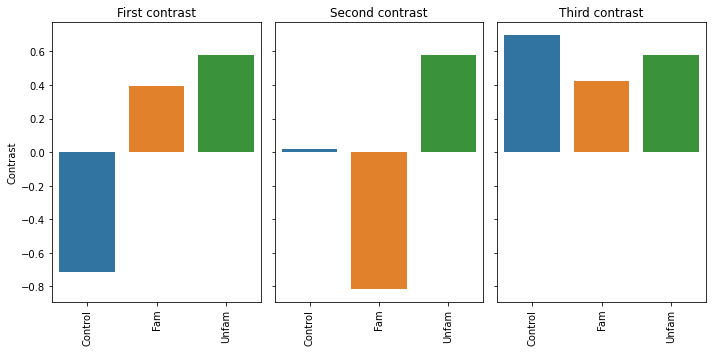

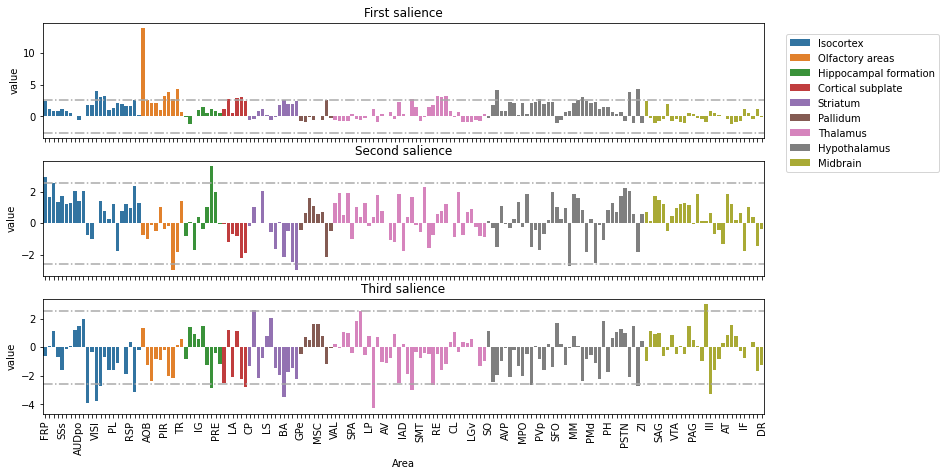

In [16]:
upls.plot_panel_contrasts(batch=batch, variable='ncells')
upls.plot_panel_saliences(batch=batch, variable='ncells', df_levels=df_levels)

# PLS ENERGY

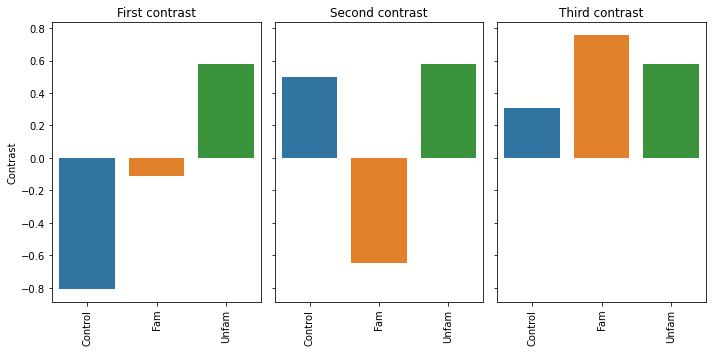

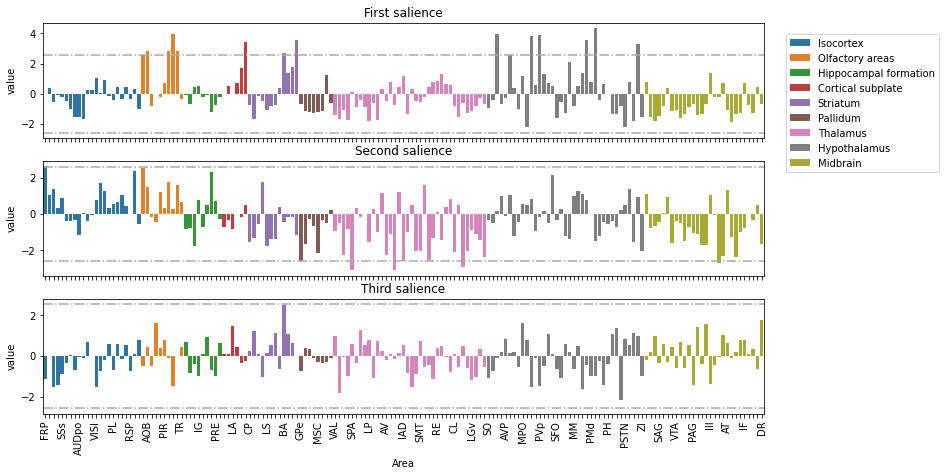

In [17]:
upls.plot_panel_contrasts(batch=batch, variable='energy')
upls.plot_panel_saliences(batch=batch, variable='energy', df_levels=df_levels)

# PLS density

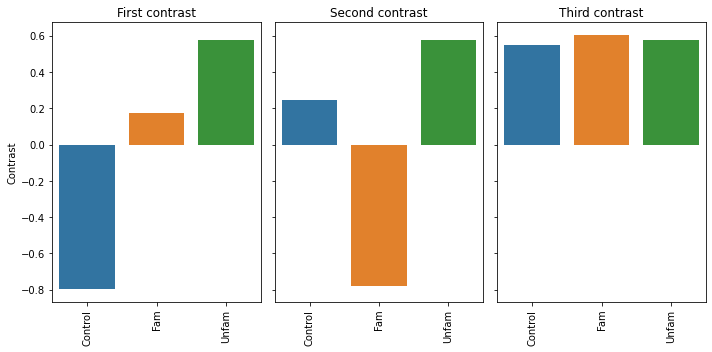

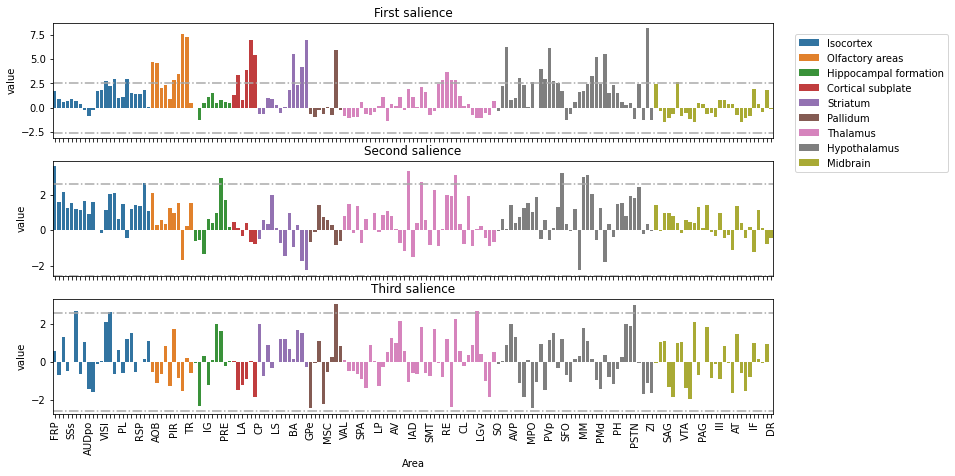

In [18]:
upls.plot_panel_contrasts(batch=batch, variable='density')
upls.plot_panel_saliences(batch=batch, variable='density', df_levels=df_levels)

# PLS relative density

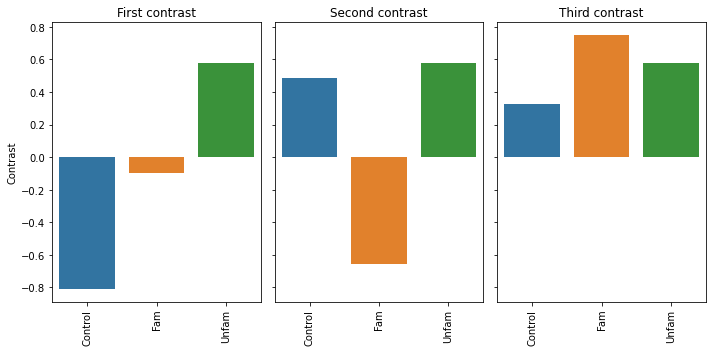

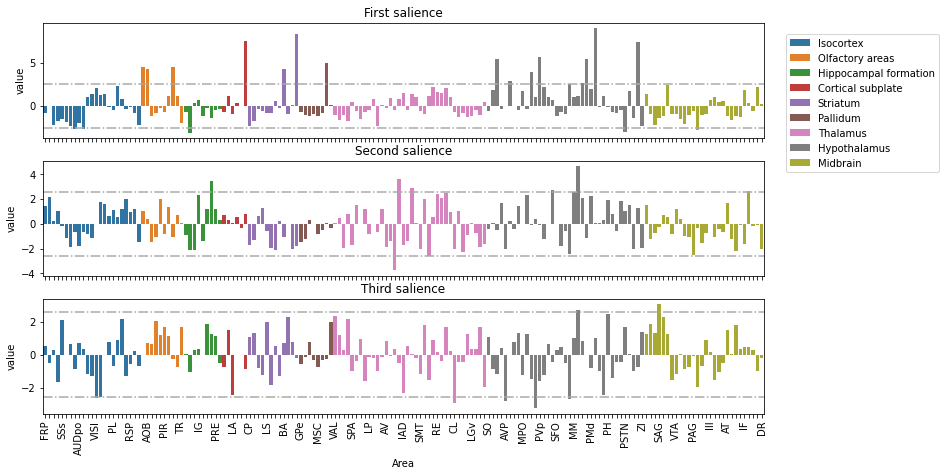

In [19]:
upls.plot_panel_contrasts(batch=batch, variable='relative_density')
upls.plot_panel_saliences(batch=batch, variable='relative_density', df_levels=df_levels)

# Identify area overlap

In [20]:
overlap = {'ncells':[], 'energy':[], 'density':[], 'relative_density':[]}
for variable in overlap.keys():
    overlap[variable] = set(upls.identify_pls_sig_areas(saliences=pd.read_csv(
        './results_pls/'+ batch +'_'+ variable +'_saliences.csv'), 
                                           threshold=2.56, 
                                           volumes=volumes))
[len(overlap[key]) for key in overlap.keys()]

[36, 20, 45, 35]

In [37]:
variable='relative_density'
np.save('results_pls/pls_sig_areas_c57.npy', upls.identify_pls_sig_areas(saliences=pd.read_csv(
        './results_pls/'+ batch +'_'+ variable +'_saliences.csv'), 
                                           threshold=2.56, 
                                           volumes=volumes))

In [21]:
overlap['relative_density']

{'Accessory olfactory bulb',
 'Anterodorsal nucleus',
 'Anteroventral periventricular nucleus',
 'Anteroventral preoptic nucleus',
 'Arcuate hypothalamic nucleus',
 'Bed nuclei of the stria terminalis',
 'Bed nucleus of the accessory olfactory tract',
 'Central lateral nucleus of the thalamus',
 'Cortical amygdalar area',
 'Dentate gyrus',
 'Interanteromedial nucleus of the thalamus',
 'Intermediodorsal nucleus of the thalamus',
 'Interpeduncular nucleus',
 'Lateral mammillary nucleus',
 'Lateral visual area',
 'Main olfactory bulb',
 'Medial amygdalar nucleus',
 'Medial mammillary nucleus',
 'Medial preoptic nucleus',
 'Nucleus sagulum',
 'Parastrial nucleus',
 'Parasubthalamic nucleus',
 'Paraventricular nucleus of the thalamus',
 'Periventricular hypothalamic nucleus posterior part',
 'Posterior amygdalar nucleus',
 'Posterodorsal preoptic nucleus',
 'Postsubiculum',
 'Pretectal region',
 'Primary auditory area',
 'Suprachiasmatic nucleus',
 'Supramammillary nucleus',
 'Tuberal nucl

In [22]:
subjects = list(dict_results_across_mice.keys())
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects)
df_control_cell_count, df_fam_cell_count, df_unfam_cell_count = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')
df_ttest_ncells = ace.test_across_groups([df_control_cell_count,df_fam_cell_count,df_unfam_cell_count])
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_ncells = df_ttest_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])
set(df_ttest_ncells[df_ttest_ncells['pval_Control_vs_Fam']<0.05]['area'].values).union(
set(df_ttest_ncells[df_ttest_ncells['pval_Control_vs_Unfam']<0.05]['area'].values)).union(
set(df_ttest_ncells[df_ttest_ncells['pval_Fam_vs_Unfam']<0.05]['area'].values))

{'Accessory olfactory bulb',
 'Arcuate hypothalamic nucleus',
 'Basomedial amygdalar nucleus',
 'Bed nuclei of the stria terminalis',
 'Bed nucleus of the accessory olfactory tract',
 'Cortical amygdalar area',
 'Infralimbic area',
 'Intercalated amygdalar nucleus',
 'Main olfactory bulb',
 'Medial amygdalar nucleus',
 'Medial preoptic nucleus',
 'Nucleus of reuniens',
 'Periventricular hypothalamic nucleus posterior part',
 'Piriform-amygdalar area',
 'Posterior amygdalar nucleus',
 'Posterodorsal preoptic nucleus',
 'Tuberal nucleus',
 'Ventral premammillary nucleus'}

In [23]:
set(df_ttest_ncells[df_ttest_ncells['pval_Control_vs_Fam']<0.05]['area'].values).union(
set(df_ttest_ncells[df_ttest_ncells['pval_Control_vs_Unfam']<0.05]['area'].values)).union(
set(df_ttest_ncells[df_ttest_ncells['pval_Fam_vs_Unfam']<0.05]['area'].values))

{'Accessory olfactory bulb',
 'Arcuate hypothalamic nucleus',
 'Basomedial amygdalar nucleus',
 'Bed nuclei of the stria terminalis',
 'Bed nucleus of the accessory olfactory tract',
 'Cortical amygdalar area',
 'Infralimbic area',
 'Intercalated amygdalar nucleus',
 'Main olfactory bulb',
 'Medial amygdalar nucleus',
 'Medial preoptic nucleus',
 'Nucleus of reuniens',
 'Periventricular hypothalamic nucleus posterior part',
 'Piriform-amygdalar area',
 'Posterior amygdalar nucleus',
 'Posterodorsal preoptic nucleus',
 'Tuberal nucleus',
 'Ventral premammillary nucleus'}

In [24]:
overlap['relative_density'].intersection(set(df_ttest_ncells[df_ttest_ncells['pval_Control_vs_Fam']<0.05]['area'].values).union(
set(df_ttest_ncells[df_ttest_ncells['pval_Control_vs_Unfam']<0.05]['area'].values)).union(
set(df_ttest_ncells[df_ttest_ncells['pval_Fam_vs_Unfam']<0.05]['area'].values)))

{'Accessory olfactory bulb',
 'Arcuate hypothalamic nucleus',
 'Bed nuclei of the stria terminalis',
 'Bed nucleus of the accessory olfactory tract',
 'Cortical amygdalar area',
 'Main olfactory bulb',
 'Medial amygdalar nucleus',
 'Medial preoptic nucleus',
 'Periventricular hypothalamic nucleus posterior part',
 'Posterior amygdalar nucleus',
 'Posterodorsal preoptic nucleus',
 'Tuberal nucleus',
 'Ventral premammillary nucleus'}

In [25]:
# union between areas significant in all analyses
all_areas = overlap['ncells'].union(overlap['energy']).union(overlap['density']).union(overlap['relative_density'])
# intersection between areas significant in all analyses
intersection = overlap['ncells'].intersection(overlap['energy']).intersection(
    overlap['density']).intersection(overlap['relative_density'])
# filtering
intersection, len(intersection)

({'Arcuate hypothalamic nucleus',
  'Bed nucleus of the accessory olfactory tract',
  'Cortical amygdalar area',
  'Medial amygdalar nucleus',
  'Periventricular hypothalamic nucleus posterior part',
  'Posterior amygdalar nucleus',
  'Posterodorsal preoptic nucleus',
  'Tuberal nucleus'},
 8)

In [26]:
wf_rd = overlap['relative_density']
wf_rd

{'Accessory olfactory bulb',
 'Anterodorsal nucleus',
 'Anteroventral periventricular nucleus',
 'Anteroventral preoptic nucleus',
 'Arcuate hypothalamic nucleus',
 'Bed nuclei of the stria terminalis',
 'Bed nucleus of the accessory olfactory tract',
 'Central lateral nucleus of the thalamus',
 'Cortical amygdalar area',
 'Dentate gyrus',
 'Interanteromedial nucleus of the thalamus',
 'Intermediodorsal nucleus of the thalamus',
 'Interpeduncular nucleus',
 'Lateral mammillary nucleus',
 'Lateral visual area',
 'Main olfactory bulb',
 'Medial amygdalar nucleus',
 'Medial mammillary nucleus',
 'Medial preoptic nucleus',
 'Nucleus sagulum',
 'Parastrial nucleus',
 'Parasubthalamic nucleus',
 'Paraventricular nucleus of the thalamus',
 'Periventricular hypothalamic nucleus posterior part',
 'Posterior amygdalar nucleus',
 'Posterodorsal preoptic nucleus',
 'Postsubiculum',
 'Pretectal region',
 'Primary auditory area',
 'Suprachiasmatic nucleus',
 'Supramammillary nucleus',
 'Tuberal nucl

In [27]:
wof_rd = {'Accessory olfactory bulb',
 'Agranular insular area',
 'Anterior amygdalar area',
 'Anterodorsal nucleus',
 'Anteromedial nucleus',
 'Bed nuclei of the stria terminalis',
 'Bed nucleus of the accessory olfactory tract',
 'Caudoputamen',
 'Cortical amygdalar area',
 'Dentate gyrus',
 'Dorsal premammillary nucleus',
 'Frontal pole cerebral cortex',
 'Fundus of striatum',
 'Lateral hypothalamic area',
 'Lateral mammillary nucleus',
 'Lateral septal nucleus',
 'Medial amygdalar nucleus',
 'Mediodorsal nucleus of thalamus',
 'Parafascicular nucleus',
 'Paraventricular hypothalamic nucleus',
 'Periventricular hypothalamic nucleus posterior part',
 'Posterior amygdalar nucleus',
 'Posterior auditory area',
 'Preparasubthalamic nucleus',
 'Primary motor area',
 'Secondary motor area',
 'Septohippocampal nucleus',
 'Subgeniculate nucleus',
 'Ventral medial nucleus of the thalamus',
 'Ventral premammillary nucleus',
 'Visceral area'}

In [28]:
wf_rd.intersection(wof_rd)

{'Accessory olfactory bulb',
 'Anterodorsal nucleus',
 'Bed nuclei of the stria terminalis',
 'Bed nucleus of the accessory olfactory tract',
 'Cortical amygdalar area',
 'Dentate gyrus',
 'Lateral mammillary nucleus',
 'Medial amygdalar nucleus',
 'Periventricular hypothalamic nucleus posterior part',
 'Posterior amygdalar nucleus',
 'Ventral premammillary nucleus'}

In [29]:
wf_rd.difference(wof_rd)

{'Anteroventral periventricular nucleus',
 'Anteroventral preoptic nucleus',
 'Arcuate hypothalamic nucleus',
 'Central lateral nucleus of the thalamus',
 'Interanteromedial nucleus of the thalamus',
 'Intermediodorsal nucleus of the thalamus',
 'Interpeduncular nucleus',
 'Lateral visual area',
 'Main olfactory bulb',
 'Medial mammillary nucleus',
 'Medial preoptic nucleus',
 'Nucleus sagulum',
 'Parastrial nucleus',
 'Parasubthalamic nucleus',
 'Paraventricular nucleus of the thalamus',
 'Posterodorsal preoptic nucleus',
 'Postsubiculum',
 'Pretectal region',
 'Primary auditory area',
 'Suprachiasmatic nucleus',
 'Supramammillary nucleus',
 'Tuberal nucleus',
 'Tuberomammillary nucleus',
 'Ventral auditory area'}

In [30]:
wof_rd.difference(wf_rd)

{'Agranular insular area',
 'Anterior amygdalar area',
 'Anteromedial nucleus',
 'Caudoputamen',
 'Dorsal premammillary nucleus',
 'Frontal pole cerebral cortex',
 'Fundus of striatum',
 'Lateral hypothalamic area',
 'Lateral septal nucleus',
 'Mediodorsal nucleus of thalamus',
 'Parafascicular nucleus',
 'Paraventricular hypothalamic nucleus',
 'Posterior auditory area',
 'Preparasubthalamic nucleus',
 'Primary motor area',
 'Secondary motor area',
 'Septohippocampal nucleus',
 'Subgeniculate nucleus',
 'Ventral medial nucleus of the thalamus',
 'Visceral area'}

In [31]:
wild_wf_rd = {'Accessory olfactory bulb',
 "Ammon's horn",
 'Anterior amygdalar area',
 'Anteroventral periventricular nucleus',
 'Basolateral amygdalar nucleus',
 'Basomedial amygdalar nucleus',
 'Bed nucleus of the accessory olfactory tract',
 'Caudoputamen',
 'Central amygdalar nucleus',
 'Central medial nucleus of the thalamus',
 'Claustrum',
 'Cortical amygdalar area',
 'Dentate gyrus',
 'Dorsal auditory area',
 'Dorsal peduncular area',
 'Endopiriform nucleus',
 'Inferior colliculus',
 'Interanterodorsal nucleus of the thalamus',
 'Lateral posterior nucleus of the thalamus',
 'Lateral terminal nucleus of the accessory optic tract',
 'Lateral visual area',
 'Magnocellular nucleus',
 'Medial amygdalar nucleus',
 'Medial habenula',
 'Mediodorsal nucleus of thalamus',
 'Midbrain reticular nucleus retrorubral area',
 'Midbrain trigeminal nucleus',
 'Orbital area',
 'Parabigeminal nucleus',
 'Parastrial nucleus',
 'Paraventricular hypothalamic nucleus descending division',
 'Periaqueductal gray',
 'Periventricular hypothalamic nucleus preoptic part',
 'Piriform area',
 'Piriform-amygdalar area',
 'Posterior amygdalar nucleus',
 'Posterior limiting nucleus of the thalamus',
 'Postpiriform transition area',
 'Primary motor area',
 'Primary somatosensory area',
 'Rhomboid nucleus',
 'Secondary motor area',
 'Septohippocampal nucleus',
 'Subiculum',
 'Substantia nigra compact part',
 'Superior colliculus motor related',
 'Supplemental somatosensory area',
 'Ventral part of the lateral geniculate complex'}


In [32]:
wild_wf_rd.intersection(wf_rd)

{'Accessory olfactory bulb',
 'Anteroventral periventricular nucleus',
 'Bed nucleus of the accessory olfactory tract',
 'Cortical amygdalar area',
 'Dentate gyrus',
 'Lateral visual area',
 'Medial amygdalar nucleus',
 'Parastrial nucleus',
 'Posterior amygdalar nucleus'}